In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, DataCollatorForSeq2Seq
from generative_model import GenerativeModel, train, test, validate
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from task2_utils import tokenize_df_gen, decode_data, compute_metrics

import sys
import os
sys.path.insert(1, '../')
import data_handler
sys.path.insert(1, '../kp_match')
import siamese_network 
from siamese_network import SiameseNetwork

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device(0)

# Data Management

In [5]:
df_train, df_val, df_test = data_handler.load_full_dataset('../dataset/', get_train=True, get_dev=True, get_test=True)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 3 to 3455
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   argument   4998 non-null   object
 1   key_point  4998 non-null   object
 2   topic      4998 non-null   object
 3   stance     4998 non-null   int64 
 4   label      4998 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 234.3+ KB


In [7]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552 entries, 3 to 3423
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   argument   552 non-null    object
 1   key_point  552 non-null    object
 2   topic      552 non-null    object
 3   stance     552 non-null    int64 
 4   label      552 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 25.9+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   argument  18398 non-null  object
 1   topic     18398 non-null  object
 2   stance    18398 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 431.3+ KB


In [9]:
print(f"Number of unique topics present in Training set: {len(df_train['topic'].unique())}")
print(f"Number of unique topics present in Validation set: {len(df_val['topic'].unique())}")
print(f"Number of unique topics present in Test set: {len(df_test['topic'].unique())}")

Number of unique topics present in Training set: 28
Number of unique topics present in Validation set: 3
Number of unique topics present in Test set: 43


In [10]:
#Check if there are some shared topics
print(f"Overlap of topics between Training and Validation: {len(np.intersect1d(df_train['topic'].unique(), df_val['topic'].unique()))}")
print(f"Overlap of topics between Training and Test: {len(np.intersect1d(df_train['topic'].unique(), df_test['topic'].unique()))}")
print(f"Overlap of topics between Test and Validation: {len(np.intersect1d(df_val['topic'].unique(), df_test['topic'].unique()))}")

Overlap of topics between Training and Validation: 0
Overlap of topics between Training and Test: 0
Overlap of topics between Test and Validation: 0


In [11]:
len_kp = pd.DataFrame()
len_kp['length'] = df_train['key_point'].apply(lambda x: len(x.split(" ")))
print(f"Maximum length of key point: {len_kp.length.max()}")
print(f"Minimum length of key point: {len_kp.length.min()}")
print(f"Mean length of key point: {len_kp.length.mean()}")

Maximum length of key point: 19
Minimum length of key point: 3
Mean length of key point: 7.303721488595438


In [12]:
# Concatenate topics and keypoints, as stated in the paper
df_train = data_handler.concatenate_topics(df_train, input_col='argument', output_col='argument')
df_val = data_handler.concatenate_topics(df_val, input_col='argument', output_col='argument')
df_test = data_handler.concatenate_topics(df_test, input_col='argument', output_col='argument')

In [13]:
n_words = pd.DataFrame()
n_words['words_per_arg_train'] = df_train['argument'].str.split().apply(len)
n_words['words_per_arg_val'] = df_val['argument'].str.split().apply(len)
n_words['words_per_arg_test'] = df_test['argument'].str.split().apply(len)

<AxesSubplot: >

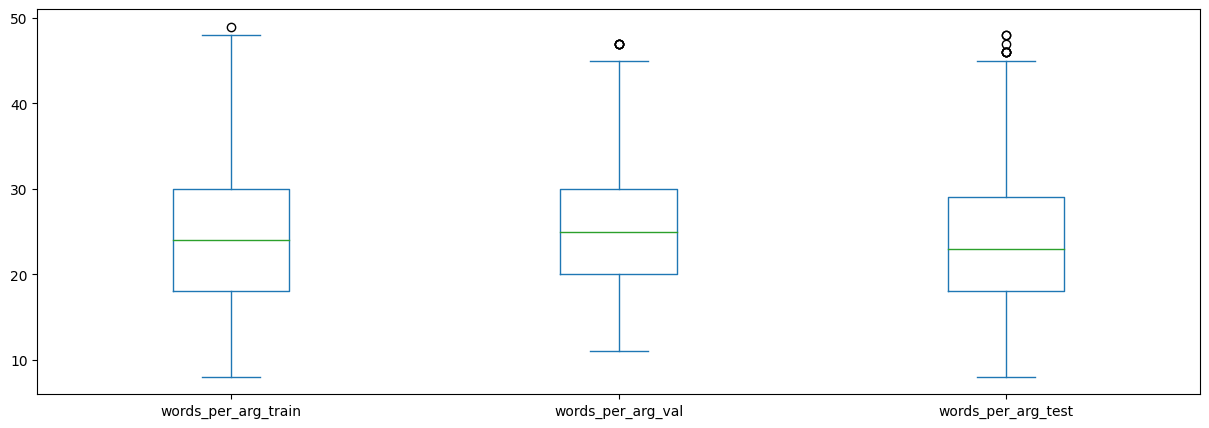

In [14]:
n_words.plot.box(figsize=(15, 5))

In [15]:
print(f"Max number of words for Training args: {n_words['words_per_arg_train'].max()}")
print(f"Max number of words for Validation args: {n_words['words_per_arg_val'].max()}")
print(f"Max number of words for Test args: {n_words['words_per_arg_test'].max()}\n")

Max number of words for Training args: 49
Max number of words for Validation args: 47.0
Max number of words for Test args: 48



# Training

In [6]:
df_train = df_train[1:100]
df_val = df_val[1:100]

In [7]:
from task2_utils import tokenize_df_gen
max_length = 128

model = PegasusModel()
tokenizer = AutoTokenizer.from_pretrained('google/pegasus-xsum')
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True, max_length=max_length)

tokenized_tr = tokenize_df_gen(df_train, tokenizer, max_length=max_length)

/storagenfs/m.melerocavallo/HLTKeyPointAnalysis/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/storagenfs/m.melerocavallo/HLTKeyPointAnalysis/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  war

In [ ]:
# Tokenizing without padding to check token lengths
args_len = [len(tokenizer.encode(s)) for s in df_train['argument']]
kps_len = [len(tokenizer.encode(s)) for s in df_train['key_point']]

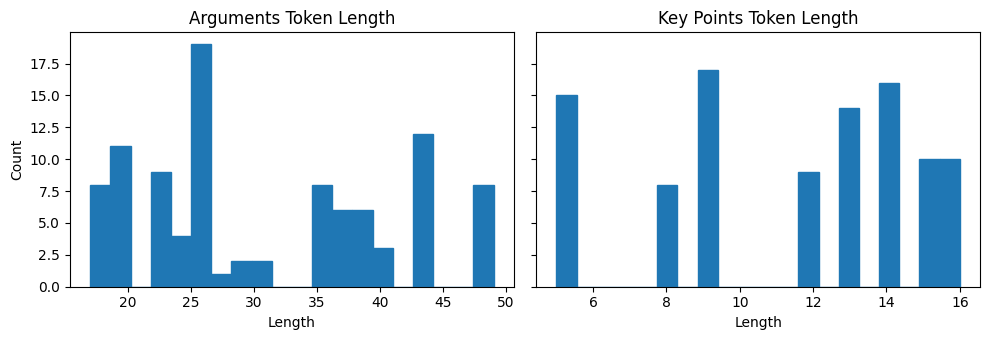

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(args_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Arguments Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(kps_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Key Points Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

# Compute baseline

In [14]:
def test_baseline(model_type, device, loss, metrics):
    tokenizer = AutoTokenizer.from_pretrained(model_type)
    max_length = 100
    
    _, df_val, df_test = data_handler.load_full_dataset('../dataset/', get_train=False, get_dev=True, get_test=True)

    # Concatenate topics and keypoints, as stated in the paper
    df_val = data_handler.concatenate_topics(df_val, input_col='argument', output_col='argument')
    df_test = data_handler.concatenate_topics(df_test, input_col='argument', output_col='argument')
    
    model = GenerativeModel(model_type)
    model.to(device)
    
    tokenized_val = tokenize_df_gen(df_val, tokenizer, max_length=max_length)

    seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True, max_length=max_length)

    val_loader = DataLoader(
        tokenized_val, # dataset di validazione
        collate_fn=seq2seq_data_collator, # data collator
        pin_memory=True
    )
    
    val_res = validate(model, device, val_loader, max_length=max_length)
    
    dec_pred, dec_exp = decode_data(val_res['predicted'], val_res['labels'], tokenizer)
    # Compute metrics
    val_metrics = compute_metrics(dec_pred, dec_exp, metrics)
    print(f"Validation results with model {model_type}:")
    print(val_metrics)
    print(f"Some validation phrases generated using {model_type}:")
    for i in range(5):
        print(f"Argument: {df_val['argument'].iloc[i]} Generated key-point: {dec_pred[i]}")

    tokenized_test = tokenize_df_gen(df_test, tokenizer, max_length=max_length, key_points_on=False)

    test_loader = DataLoader(
        tokenized_test, # dataset di validazione
        collate_fn=seq2seq_data_collator, # data collator
        pin_memory=True
    )

    test_res = test(model, device, test_loader, max_length=max_length)

    dec_pred = tokenizer.batch_decode(test_res['predicted'], skip_special_tokens=True, clean_up_tokenization_spaces=True)
    print(f"Some test phrases generated using {model_type}:")
    for i in range(5):
        print(f"Argument: {df_test['argument'].iloc[i]} Generated key-point: {dec_pred[i]}")


In [ ]:
model_type = 'google/pegasus-xsum'
test_baseline(model_type, device, None, ['rouge']) 